In [ ]:
!pip install "popgym[baselines]"
!git clone https://github.com/john-science/mazelib.git
!pip install -r mazelib/requirements.txt
!pip install mazelib/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

Processing ./mazelib
  Preparing metadata (setup.py) ... done
  Created wheel for mazelib: filename=mazelib-0.9.14-cp310-cp310-linux_x86_64.whl size=4262027 sha256=f3938a12909b8a7b16ba1f471de44cddad8ce16292e04ade446c2a93426d7721
  Stored in directory: /tmp/pip-ephem-wheel-cache-8mn6eshh/wheels/a1/3f/16/8cc1320f205dd2a2df57737f1264d96687e4665503657d3c53
Successfully built mazelib


In [ ]:
"""A procedurally-generated maze that the agent must explore

The agent is dropped into a procedurally-generated maze and must explore
it. The agent receives reward for visiting new grid squares. Once all squares
are visited or the time limit is reached, the episode ends."""

from typing import Any, Dict, Optional, Tuple

import gymnasium as gym
import numpy as np
from gymnasium.core import ActType, ObsType

from popgym.core.maze import Actions, Cell, Explored, MazeEnv


class LabyrinthExplore(MazeEnv):
    """A procedurally-generated maze that the agent must explore

    The agent is dropped into a procedurally-generated maze and must explore
    it. The agent receives reward for visiting new grid squares. Once all squares
    are visited or the time limit is reached, the episode ends.

    Args:
        maze_dims: (heigh, width) of the generated mazes in blocks
        episode_length: maximum length of an episode

    Returns:
        A gym environment

    """

    def __init__(self, maze_dims=(10, 10), episode_length=1024):
        super().__init__(maze_dims, episode_length)
        self.neg_reward_scale = -1 / self.max_episode_length

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:
        new_square = self.explored[tuple(self.move(action))] == Explored.NO
        super().step(action)
        reward = self.neg_reward_scale
        terminated = truncated = False
        y, x = self.position
        if new_square:
            reward = self.pos_reward_scale
        if self.curr_step == self.max_episode_length - 1:
            truncated = True
        free_mask = self.maze.grid != Cell.OBSTACLE
        visit_mask = self.explored == Explored.YES
        if np.all(free_mask == visit_mask):
            # Explored as much as possible
            terminated = True

        obs = self.get_obs(action)
        info = {"position": (x, y)}

        return obs, reward, terminated, truncated, info

    def render(self):
        return self.tostring(start=True, end=False, agent=True, visited=True)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[gym.core.ObsType, Dict[str, Any]]:
        super().reset(seed=seed)
        # Based on free space
        self.pos_reward_scale = 1 / ((self.maze.grid == Cell.FREE).sum())
        y, x = self.position
        obs = self.get_obs(Actions.NONE)
        return obs, {"maze": str(self.maze.grid)}


class LabyrinthExplore_8(LabyrinthExplore):
    def __init__(self):
        super().__init__(maze_dims=(8, 8), episode_length=1024)


class LabyrinthExplore_10(LabyrinthExplore):
    def __init__(self):
        super().__init__(maze_dims=(10, 10), episode_length=1024)


class LabyrinthExplore_12(LabyrinthExplore):
    def __init__(self):
        super().__init__(maze_dims=(12, 12), episode_length=1024)

In [ ]:
"""The agent is dropped in a procedurally-generated maze and must escape

A maze environment where the agent receives negative rewards
until it finds the goal. The goal is the "exit" of the maze.
It exists somewhere along the border of the maze. Once the agent
reaches the goal or the time limit is reached, the episode ends."""
from typing import Any, Dict, Optional, Tuple

import gymnasium as gym
from gymnasium.core import ActType, ObsType

from popgym.core.maze import Actions, Cell, MazeEnv


class LabyrinthEscape(MazeEnv):
    """The agent is dropped in a procedurally-generated maze and must escape

    A maze environment where the agent receives negative rewards
    until it finds the goal. The goal is the "exit" of the maze.
    It exists somewhere along the border of the maze. Once the agent
    reaches the goal or the time limit is reached, the episode ends.

    Args:
        maze_dims: (heigh, width) of the generated mazes in blocks
        episode_length: maximum length of an episode

    Returns:
        A gym environment

    """

    def __init__(self, maze_dims=(10, 10), episode_length=1024):
        super().__init__(maze_dims, episode_length)
        self.neg_reward_scale = -1 / self.max_episode_length

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:
        super().step(action)
        reward = self.neg_reward_scale
        terminated = False
        y, x = self.position
        if self.maze.grid[y, x] == Cell.GOAL:
            reward += 1.0
            terminated = True
        truncated = self.curr_step == self.max_episode_length - 1

        obs = self.get_obs(action)
        info = {"position": (x, y)}

        return obs, reward, terminated, truncated, info

    def render(self):
      def tostring(start=False, end=False, agent=False, visited=False):
        """Return a string representation of the maze.
        This can also display the maze entrances/solutions IF they already exist.
        Args:
            entrances (bool): Do you want to show the entrances of the maze?
            solutions (bool): Do you want to show the solution to the maze?
        Returns:
            str: string representation of the maze
        """
        # build the walls of the grid
        txt = []
        for i, row in enumerate(self.maze.grid):
            col = []
            for j, cell in enumerate(row):
                if visited and self.explored[i, j] == 1:
                    col += ["++"]
                elif cell == 0:
                    col += ["  "]
                elif cell == 1:
                    col += ["██"]
            txt.append("".join(col))

        # insert the start and end points
        if start and self.maze.start:
            if self.maze.start != self.position:
                r, c = self.maze.start
                txt[r] = txt[r][: 2 * c] + "🟢" + txt[r][2 * (c + 1) :]
        if end and self.maze.end:
            if self.maze.end != self.position:
                r, c = self.maze.end
                txt[r] = txt[r][: 2 * c] + "🛑" + txt[r][2 * (c + 1) :]
        if agent:
            r, c = self.position
            txt[r] = txt[r][: 2 * c] + "🚎" + txt[r][2 * (c + 1) :]

        return "\n".join(txt)


      return tostring(start=True, end=True, agent=True, visited=True)


    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[gym.core.ObsType, Dict[str, Any]]:
        super().reset(seed=seed)
        # Based on free space
        x, y = self.position
        self.maze.grid[self.maze.end] = Cell.GOAL
        obs = self.get_obs(Actions.NONE)

        return obs, {"maze": str(self.maze.grid)}


class LabyrinthEscape_8(LabyrinthEscape):
    def __init__(self):
        super().__init__(maze_dims=(8,8), episode_length=1024)


class LabyrinthEscape_10(LabyrinthEscape):
    def __init__(self):
        super().__init__(maze_dims=(10, 10), episode_length=1024)


class LabyrinthEscape_12(LabyrinthEscape):
    def __init__(self):
        super().__init__(maze_dims=(12, 12), episode_length=1024)

ENVIRONMENT USED:  LabyrinthEscape_8
#########For seed num :0 and seed value : 6906#######


/usr/local/lib/python3.10/dist-packages/popgym/core/maze.py:62: DeprecationWarning: Maze environments have been shown to be solvable without the use of memory (e.g. MLP outperforms LSTM). We suggest not using them as POMDP benchmarks.
  warn(


Episode done Final Exit reached after steps :597
Episode 1 finished with total cumulative sum of rewards : 0.4169921875 
#########For seed num :1 and seed value : 4122#######
1024 steps reached stopping episode
Episode 1 finished with total cumulative sum of rewards : -1.0 
#########For seed num :2 and seed value : 3985#######
Episode done Final Exit reached after steps :227
Episode 1 finished with total cumulative sum of rewards : 0.7783203125 
#########For seed num :3 and seed value : 7102#######
Episode done Final Exit reached after steps :299
Episode 1 finished with total cumulative sum of rewards : 0.7080078125 
#########For seed num :4 and seed value : 93#######
Episode done Final Exit reached after steps :638
Episode 1 finished with total cumulative sum of rewards : 0.376953125 
#########For seed num :5 and seed value : 5894#######
1024 steps reached stopping episode
Episode 1 finished with total cumulative sum of rewards : -1.0 
#########For seed num :6 and seed value : 6843###

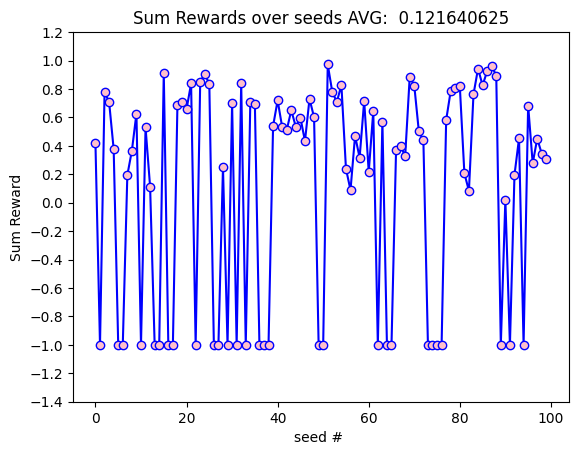

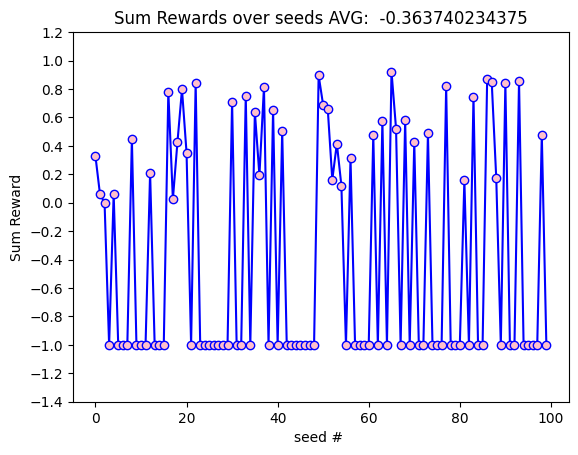

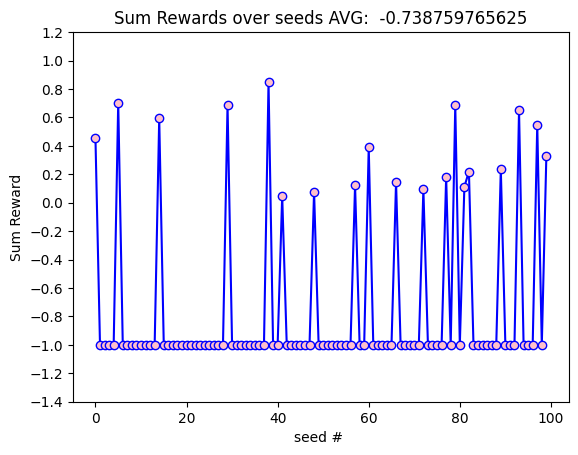

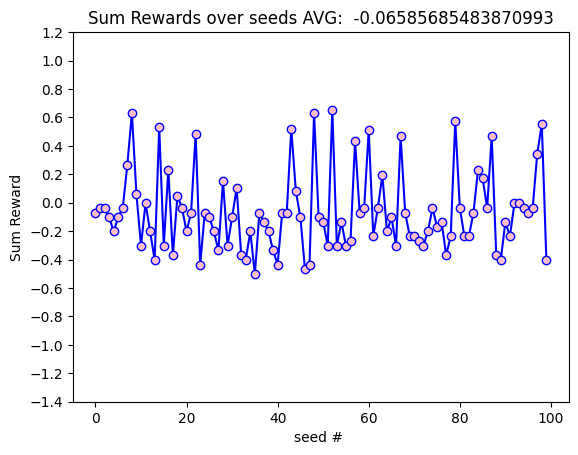

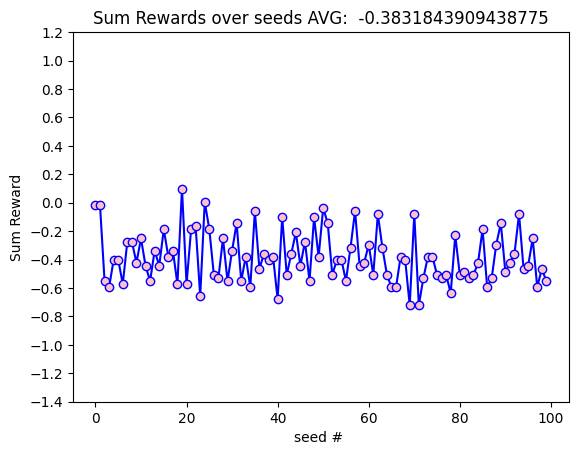

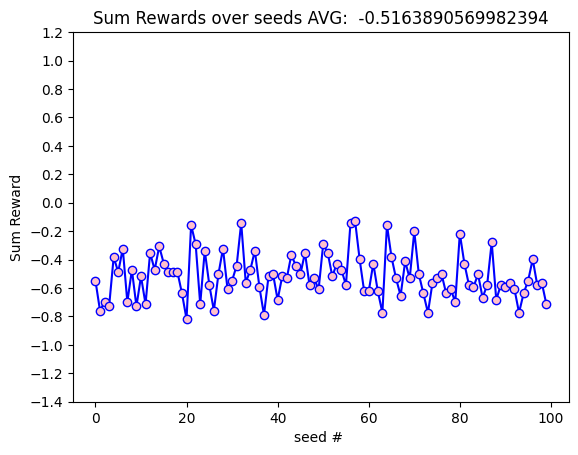

In [ ]:
import gym
import numpy as np
import imageio
from PIL import Image
import numpy as np
import imageio
import random
import popgym

class RandomAgent:
    def __init__(self, action_space,seed):
        self.action_space = action_space
        self.seed = seed
        if self.seed is not None:
            random.seed(self.seed)

    def act(self, observation, reward, done):
        return self.action_space.sample()

seeds=[ 6906,	4122,	3985,	7102,	93,	5894,	6843,7219,	8968,	4784,
4468,	9758,	5174,	3578,	8974,	595,	9877,	9131,	9662,	9205,
1869,	5759,	4519,	5626,	674,	5386,	8668,	4865,	7432,	3424,
4433,	3273,	6940,	3768,	7020,	2887,	1626,	6447,	9146,	9791,
6234,	7124,	419,	4699,	816	,408,	9531,3453,	5626,	7622,
7795,	7035,	9503, 3321,	6671,	83,	5903,	9241,	1742,	9787,
3015,	7582,	7473,	5968,	6979,	8776,	8453,	4349,	7919,3475,
1974,	9042,	921,	4050,	1007,	9190,	1780,	245,2348,	7351,
1460,	8846,	6986,	4777,	4862,	7549,	4046,	7832,	8876,	4698,
9915,	7092,	9683,	8555,	4869,	5217,	1701,	8704,	6775,	837,
]
list_of_envs=["LabyrinthEscape_8", "LabyrinthEscape_10", "LabyrinthEscape_12", "LabyrinthExplore_8", "LabyrinthExplore_10", "LabyrinthExplore_12"]

for env_name in list_of_envs:
  print("ENVIRONMENT USED: ", env_name )
  list_sum_rewards=[]
  for index,seed in enumerate(seeds):
    print(f"#########For seed num :{index} and seed value : {seed}#######")
    difficulty=env_name.split("_")[1]
    task=env_name.split("_")[0]

    if difficulty=="8":

      if task=="LabyrinthEscape":
        env = LabyrinthEscape_8()
      elif task=="LabyrinthExplore":
        env = LabyrinthExplore_8()

    elif difficulty=="10":

      if task=="LabyrinthEscape":
        env = LabyrinthEscape_10()
      elif task=="LabyrinthExplore":
        env = LabyrinthExplore_10()

    elif difficulty=="12":

      if task=="LabyrinthEscape":
        env = LabyrinthEscape_12()
      elif task=="LabyrinthExplore":
        env = LabyrinthExplore_12()


    #print(f"max spisode length: {env.max_episode_length}")

    # Initialize the agent
    agent = RandomAgent(env.action_space,seed)

    # Number of episodes
    episodes = 1

    for i_episode in range(episodes):
        #print("#########For Episode number :",i_episode+1)
        observation = env.reset(seed=seed)
        rewards = 0
        terminated = False
        mazes=[]
        count=0
        while not terminated:
            count+=1

            #print("Step taken:",count)
            # Uncomment the line below to render the environment
            # user_input = ''
            # while user_input != 'q':
            #   user_input = input()
            maze = env.render()
            mazes.append(maze)

            action = agent.act(observation, rewards, terminated)
            obs, reward, terminated, truncated, info =step_taken = env.step(action)
            #print(step_taken)
            #print(f"Action taken :{action} with reward: {reward} and pos : {position['position'] }")
            if terminated == True:
              print(f"Episode done Final Exit reached after steps :{count}")
              #print(step_taken)
              #print(env.render())
            rewards += reward
            if count == 1024:
              print("1024 steps reached stopping episode")
              #print(f"Episode done Final Exit reached after steps :{count}")
              #print(step_taken)
              #print(env.render())
              break
        print(f"Episode {i_episode + 1} finished with total cumulative sum of rewards : {rewards} ")
        list_sum_rewards.append(rewards)
    env.close()
  # import seaborn and matplotlib

  import matplotlib.pyplot as plt
  from statistics import mean
  fig, ax = plt.subplots()
  # plot the cumulative distribution function using kdeplot
  ax.plot(list_sum_rewards, color="blue", marker="o", mfc="pink")
  avg_cum_reward_over_seeds=mean(list_sum_rewards)
  ax.set_ylabel("Sum Reward")
  ax.set_xlabel("seed # ")
  ax.set_title(f"Sum Rewards over seeds AVG:  {avg_cum_reward_over_seeds}")
  ax.set_ylim(-1, 1)
  ax.set_yticks(np.arange(-1.4,1.4,0.2))
  # show the plot
  fig.savefig(f"/content/drive/MyDrive/CMPUT 655 Random Agent/{env_name}_environment_random_avg_of_100_seed_1_episode_per_seed.png")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
